In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from matplotlib.gridspec import GridSpec
from astropy.table import Table, vstack, Column, MaskedColumn
from astropy import units as u
from scipy.stats import kde
from scipy.stats import binned_statistic as b_s
from scipy.stats import binned_statistic_2d as bs2d
from astropy import units as un
from astropy import constants as con
from matplotlib.lines import Line2D

from astropy.cosmology import Planck15
from tqdm import trange
from scipy.stats import ks_2samp
from scipy import special
import scipy
from scipy.stats import anderson_ksamp



# Import Data Table

In [2]:
import os
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

plt.rc('path', simplify=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='xx-large', facecolor='none', linewidth=0.7)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
#plt.rc('savefig', facecolor='none', frameon='False')

params =   {'font.size' : 16,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
plt.rcParams.update(params) 

np.warnings.filterwarnings('ignore')

def legend_outside_plot(ax,location='top',ncol=3,pad=0, handles=None, labels=None):
    if handles==None:
        handles, labels = ax.get_legend_handles_labels()
    if location=='top':
        leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0,1.02+pad,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=ncol)
    else:
        print("Location",location,"not implemented. Please code up")
    return leg

In [3]:
data= Table.read('Yang_GZ2', format='fits')

In [4]:
data

<Table masked=True length=56598>
col1_1  col2_1 col3_1 ... REDNESS_BALDRY06      Separation     
                      ...                         arcsec       
int32   int32  int32  ...     float32            float64       
------ ------- ------ ... ---------------- --------------------
     1     750  51109 ...       0.18945384  0.02230217295198769
    15    1071  17856 ...       -0.6084719 0.009507079444144886
    17    1083  51115 ...       -0.3560989  0.02517353005013121
    19    1122  17857 ...       0.13927794 0.034807167623189084
    23    1128  26451 ...      -0.39585495   0.0480920862029093
    24    1130  51117 ...        -0.300349   0.0422346868785449
    52    1886  51140 ...        0.2899289 0.015803854953698456
    54    1890  51142 ...       -0.3125441 0.011210805934887096
    56    1899  51144 ...       0.15975642   0.0149972006286866
   ...     ...    ... ...              ...                  ...
599237 2506567   5262 ...        0.4074247 0.014026861836053346
599242 2506576   2785 ...       0.37780333 0.040207323071795066
599248 2506582   2785 ...       -0.4384203  0.07209751405407597
599250 2506596 473771 ...       -0.6716633  0.02253581080482617
599252 2506602 473772 ...      -0.50224423  0.03495757318603603
599254 2506606 473774 ...       -0.4035499 0.053140691032377625
599258 2506617 473778 ...       0.21136165    0.075780462223687
599263 2506626 473781 ...       -0.4219513  0.08712981409882403
599288 2506684 473793 ...      -0.25816512 0.026527734140579216
599290 2506690 473794 ...       0.13617921  0.02185322549037412

In [5]:
M = data['AVG_MASS']
b = [-0.12441002*i**2 + 3.3532002*i -12.08089019 - 0.21 for i in M]
delta_Sigma_1A = MaskedColumn(name = "delta_Sigma_1A", data = np.subtract(data['Sigma_1'], b) , dtype=np.float64)
data.add_column(delta_Sigma_1A)
#data.replace_column('delta_Sigma_1A',delta_Sigma_1A )


# Make cuts

In [6]:
def ms_sfr(mass, z):
    return (mass/1e9) * 2.5 * (mass/1e10)**(-0.1) * (Planck15.age(z).to(un.Gyr)/(3.5*un.Gyr))**(-2.2) # sol mass per year

delta_SFR = MaskedColumn(name='delta_SFR', data=data['AVG_SFR'] - np.log10(ms_sfr(10**data['AVG_MASS'], data['col5_2'])), mask=data['AVG_MASS'].mask)
data.add_column(delta_SFR)

red = data[data['delta_SFR']<-0.45]
blue = data[data['delta_SFR']>-0.45]

low = data[data['AVG_MASS']<=10]


high = data[data['AVG_MASS']>=10.5]


middle = data[np.logical_and((data['AVG_MASS'] >= 10), (data['AVG_MASS'] <=10.5))]

#spirals = data[data['t01_smooth_or_features_a02_features_or_disk_debiased']*data['t02_edgeon_a05_no_debiased']*data['t04_spiral_a08_spiral_debiased'] > 0.5]
spirals = data[data['t01_smooth_or_features_a02_features_or_disk_flag']*data['t02_edgeon_a05_no_flag']*data['t04_spiral_a08_spiral_flag'] ==1]
#spirals = data[data['t04_spiral_a08_spiral_debiased']>0.8]
ellipticals = data[data['t01_smooth_or_features_a01_smooth_debiased']>0.8]



In [7]:
angdiamdist = Planck15.angular_diameter_distance(data['col5_2'])*(1/un.radian)
R90_KPC = (data['R90_ARCSEC']*un.arcsec)*angdiamdist.to(un.kpc/un.arcsec)
print (R90_KPC)
R90_KPC = Column(name='R90_KPC', data=R90_KPC)
data.add_column(R90_KPC)
#data.replace_column('R90_KPC',R90_KPC )
spirals = data[data['t01_smooth_or_features_a02_features_or_disk_flag']*data['t02_edgeon_a05_no_flag']*data['t04_spiral_a08_spiral_flag'] ==1]
#spirals = data[data['t04_spiral_a08_spiral_debiased']>0.8]
ellipticals = data[data['t01_smooth_or_features_a01_smooth_debiased']>0.8]


[9.73377509 3.20444507 5.96146606 ... 6.52859223 7.56304637 8.19133897] kpc


Radius split on concentration and mass 

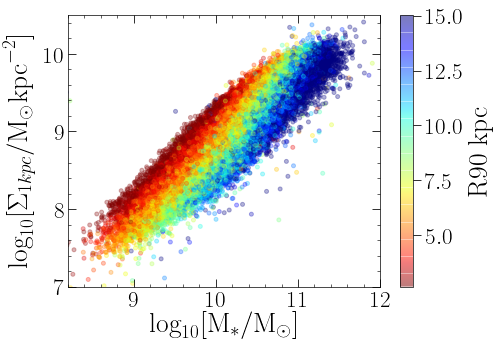

In [8]:
plt.figure(figsize=(7, 5))
H, X, Y = np.histogram2d(data['AVG_MASS'], data['Sigma_1'], bins=20, range=((8.5, 12.5),(7.5, 10.5)))
#cont = ax4.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#plt.scatter(red['AVG_MASS'], red['Sigma_1'], c='r', alpha=0.1)
#plt.scatter(blue['AVG_MASS'], blue['Sigma_1'], c='b', alpha=0.1)
plt.scatter(data['AVG_MASS'], data['Sigma_1'], c =data['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3 )
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlabel(r'$\log_{10}[\rm{M}_{\rm{*}}/M_{\odot}]$')
plt.ylabel(r'$\log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
plt.ylim(7, 10.5)
plt.xlim(8.2, 12)
cbar = plt.colorbar()
cbar.set_label(r'R90 kpc')
plt.savefig('figures/M-S1-Coloured.png')




find curve

In [9]:
#find curve

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
m = np.linspace(9,15, 20)

def func(x, a, b, c):
    return a*x + b*x**2 + c 

xdata = red['AVG_MASS'][np.logical_and(np.isfinite(red['AVG_MASS']), np.isfinite(red['Sigma_1']))]
xdata1 = np.array([i*1 for i in xdata])

ydata = red['Sigma_1'][np.logical_and(np.isfinite(red['AVG_MASS']), np.isfinite(red['Sigma_1']))]
ydata1 = np.array([i*1 for i in ydata])


popt, pcov = curve_fit(func, xdata1, ydata1)
r = [-0.2220688*i**2 + 5.42502873*i -23.05612886 - 0.21 for i in m] # log0.21 dex down
print (popt)

[  5.42502873  -0.22206887 -23.05612886]


# Figure 1a

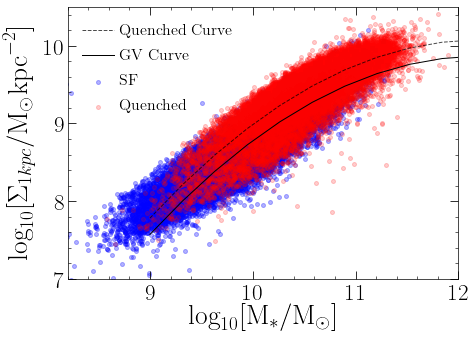

In [10]:



plt.figure(figsize=(7, 5))
H, X, Y = np.histogram2d(data['AVG_MASS'], data['Sigma_1'], bins=20, range=((8.5, 12.5),(7.5, 10.5)))
#cont = ax4.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(blue['AVG_MASS'], blue['Sigma_1'], c='b', alpha=0.3, label='SF')
plt.scatter(red['AVG_MASS'], red['Sigma_1'], c='r', alpha=0.2, label ='Quenched')
plt.plot(m, func(m, *popt), c = 'black', alpha = 0.7, ls = '--', label = 'Quenched Curve')
plt.plot(m, r, c = 'black', label = 'GV Curve')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlabel(r'$\log_{10}[\rm{M}_{\rm{*}}/M_{\odot}]$')
plt.ylabel(r'$\log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
plt.ylim(7, 10.5)
plt.xlim(8.2, 12)
plt.legend(loc= 2)
plt.savefig('figures/M-S1-Curves.png')


In [11]:
M = data['AVG_MASS']
b = [-0.12441002*i**2 + 3.3532002*i -12.08089019 - 0.21 for i in M]
delta_Sigma_1A = MaskedColumn(name = "delta_Sigma_1A", data = np.subtract(data['Sigma_1'], b) , dtype=np.float64)
#data.add_column(delta_Sigma_1A)
data.replace_column('delta_Sigma_1A',delta_Sigma_1A )


Plot of Quenched and SF

(1.2, -3)

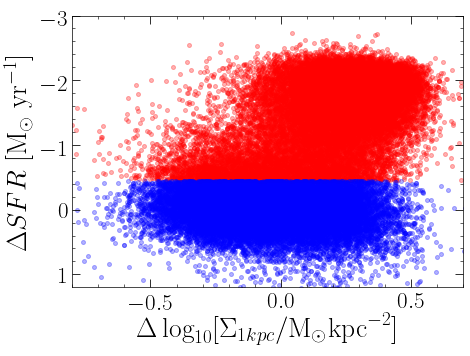

In [12]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(red['delta_Sigma_1A'], red['delta_SFR'], c='red', alpha=0.3)
plt.scatter(blue['delta_Sigma_1A'], blue['delta_SFR'], c='blue', alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)




# Split by Morphology - No SFR sample matching

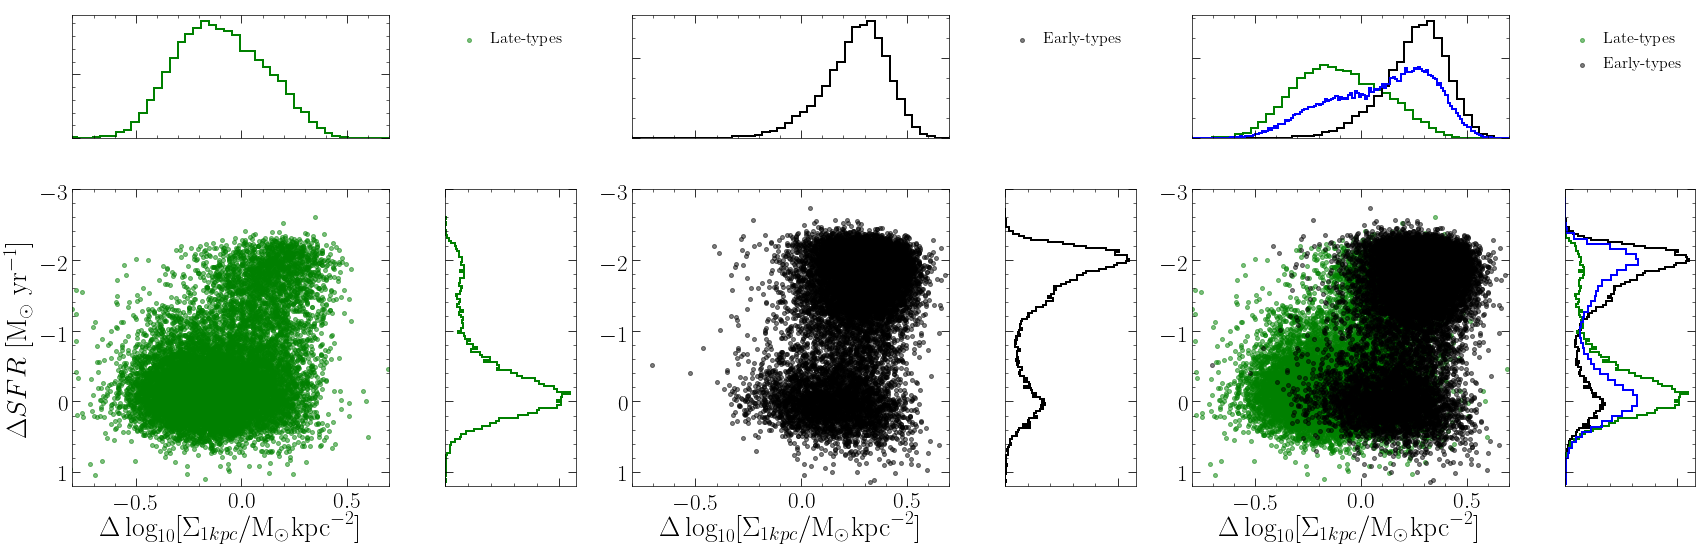

In [13]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(spirals['delta_Sigma_1A'], spirals['delta_SFR'], c='green',label='Late-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(spirals['delta_Sigma_1A'], bins=150, histtype='step', color='green', density=True, lw=2, label="Spirals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(spirals['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Spirals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(ellipticals['delta_Sigma_1A'], ellipticals['delta_SFR'], c='black',label='Early-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(ellipticals['delta_Sigma_1A'], bins=150, histtype='step', color='black', density=True, lw=2, label="Ellipticals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(ellipticals['delta_SFR'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(spirals['delta_Sigma_1A'], spirals['delta_SFR'], c='green',label='Late-types', alpha=0.5)
ax.scatter(ellipticals['delta_Sigma_1A'], ellipticals['delta_SFR'], c='black',label='Early-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(spirals['delta_Sigma_1A'], bins=150,  histtype='step', color='green', density=True, lw=2, label="Spirals")
ax.hist(ellipticals['delta_Sigma_1A'], bins=150,  histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(data['delta_Sigma_1A'], bins=150,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(ellipticals['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(spirals['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Spirals")
ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-GB-Alldata.png')

plt.tight_layout()

In [14]:
central = data[data['col4_1']==1]
satellite = data[data['col4_1']==2]

In [15]:
KS  = ks_2samp(central['delta_Sigma_1A'][np.isfinite(central['delta_Sigma_1A'])],satellite['delta_Sigma_1A'][np.isfinite(satellite['delta_Sigma_1A'])] )
AD = anderson_ksamp([central['delta_Sigma_1A'][np.isfinite(central['delta_Sigma_1A'])],satellite['delta_Sigma_1A'][np.isfinite(satellite['delta_Sigma_1A'])]])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)

Anderson_ksampResult(statistic=3.372188867721707, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.013906177726851985)
Ks_2sampResult(statistic=0.015115075814255113, pvalue=0.027945956453559278)
2.459677851090476


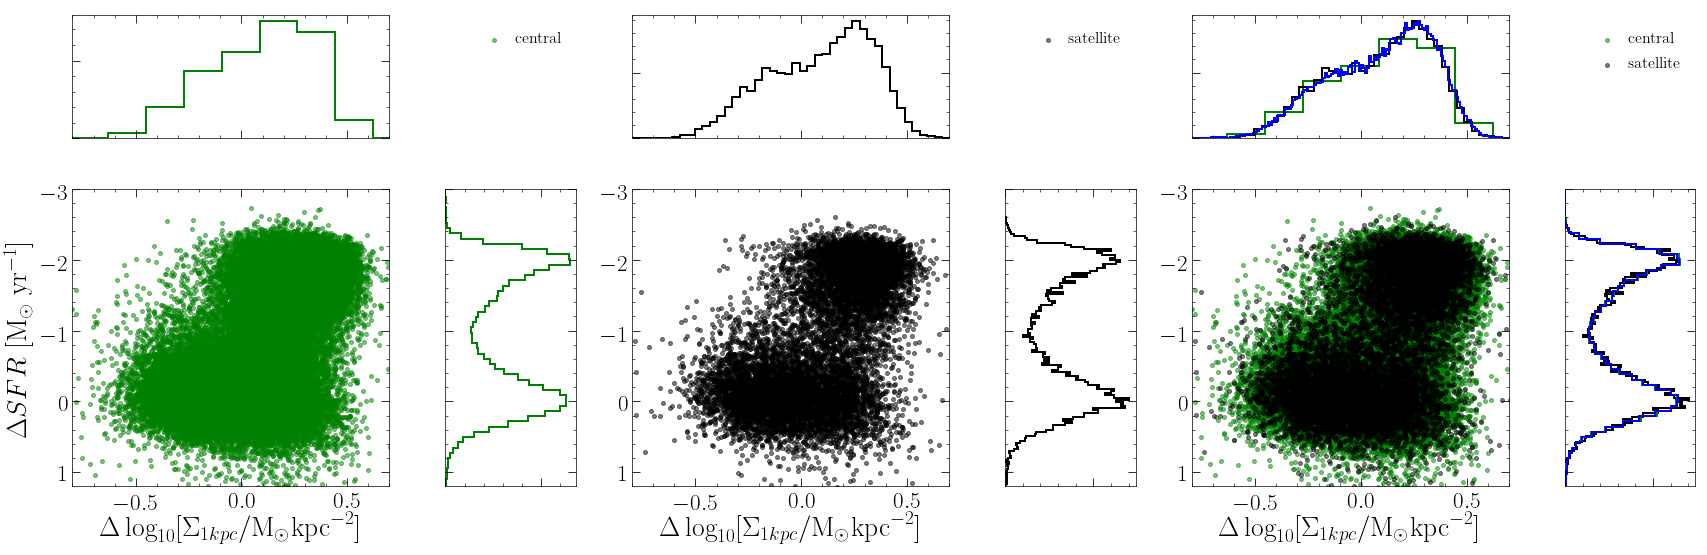

In [16]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(central['delta_Sigma_1A'], central['delta_SFR'], c='green',label='central', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(central['delta_Sigma_1A'], bins=150, histtype='step', color='green', density=True, lw=2, label="central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(central['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(satellite['delta_Sigma_1A'], satellite['delta_SFR'], c='black',label='satellite', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(satellite['delta_Sigma_1A'], bins=150, histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(satellite['delta_SFR'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(central['delta_Sigma_1A'], central['delta_SFR'], c='green',label='central', alpha=0.5)
ax.scatter(satellite['delta_Sigma_1A'], satellite['delta_SFR'], c='black',label='satellite', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(central['delta_Sigma_1A'], bins=150,  histtype='step', color='green', density=True, lw=2, label="central")
ax.hist(satellite['delta_Sigma_1A'], bins=150,  histtype='step', color='black', density=True, lw=2, label="satellite")
ax.hist(data['delta_Sigma_1A'], bins=150,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(satellite['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
ax.hist(central['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-SatVsCent-Alldata.png')

plt.tight_layout()

# Limiting data set by SFR matching

First - for spirals and ellipticals, then centrals and satellites and then Ivan Denisity, low and high density

In [17]:
#find number of spirals in each bin
bins = np.linspace(-3., 2., 100)
spiral_bins = np.digitize(spirals['delta_SFR'],bins)
#print (spiral_bins)
spiral_bincount = np.bincount(spiral_bins,  minlength = 103)
#print (spiral_bincount)
#print (len(spiral_bincount))
#print(np.max(spiral_bins))
#print(spiral_bincount[8])

In [18]:
spiral_index = []
for y in range(0,101):
    spiral_index.append(np.where(spiral_bins==y))   
#print(spiral_index)

In [19]:
bins = np.linspace(-3., 2., 100)
elliptical_bins = np.digitize(ellipticals['delta_SFR'],bins)
#print (elliptical_bins)
elliptical_bincount = np.bincount(elliptical_bins,  minlength = 103)
#print (elliptical_bincount)
#print (len(np.bincount(elliptical_bins,  minlength = 103)))
#print (elliptical_bincount[74])


In [20]:
elliptical_index = []
for y in range(0,101):
    elliptical_index.append(np.where(elliptical_bins==y))
    
#print (elliptical_index)

In [21]:
elliptical_index_mod = []
for i in range(9,74):
     elliptical_index_mod.append(np.random.choice(elliptical_index[i][0], spiral_bincount[i]))
#print(elliptical_index_mod)

In [22]:
spiral_index = []
for y in range(9,74):
    spiral_index.append(np.where(spiral_bins==y))   
#print(spiral_index)

In [23]:
o = list(np.array(spiral_index).flatten())
indexs = np.concatenate(o)
#print (indexs)

In [24]:
h = list(np.array(elliptical_index_mod).flatten())
index = np.concatenate(h)
#print (index)

In [25]:
bins = np.linspace(-3., 2., 100)
central_bins = np.digitize(central['delta_SFR'],bins)
#print (spiral_bins)
central_bincount = np.bincount(central_bins,  minlength = 103)
#print (spiral_bincount)
#print (len(spiral_bincount))
#print(np.max(spiral_bins))
#print(spiral_bincount[8])

central_index = []
for y in range(0,101):
    central_index.append(np.where(central_bins==y))   
#print(spiral_index)

bins = np.linspace(-3., 2., 100)
satellite_bins = np.digitize(satellite['delta_SFR'],bins)
#print (elliptical_bins)
satellite_bincount = np.bincount(satellite_bins,  minlength = 103)
#print (elliptical_bincount)
#rint (len(np.bincount(elliptical_bins,  minlength = 103)))
#print (elliptical_bincount[74])


satellite_index = []
for y in range(0,101):
    satellite_index.append(np.where(satellite_bins==y))

satellite_index_mod = []
for i in range(9,74):
     satellite_index_mod.append(np.random.choice(satellite_index[i][0], central_bincount[i]))

central_index = []
for y in range(9,74):
    central_index.append(np.where(central_bins==y))   

c1 = list(np.array(central_index).flatten())
index_c1 = np.concatenate(c1)


st1 = list(np.array(satellite_index_mod).flatten())
index_st1 = np.concatenate(st1)


Ilow = data[data['IVAN_DENSITY']<=np.percentile(data['IVAN_DENSITY'], 50)]

Ihigh = data[data['IVAN_DENSITY']>=np.percentile(data['IVAN_DENSITY'], 50)]

#Ilow = data[np.logical_and((data['IVAN_DENSITY'] >= np.percentile(data['IVAN_DENSITY'], 20)), (data['IVAN_DENSITY'] <=np.percentile(data['IVAN_DENSITY'], 50)))]

#Ihigh = data[np.logical_and((data['IVAN_DENSITY'] >= np.percentile(data['IVAN_DENSITY'], 50)), (data['IVAN_DENSITY'] <=np.percentile(data['IVAN_DENSITY'], 80)))]


bins = np.linspace(-3., 2., 100)
Ilow_bins = np.digitize(Ilow['delta_SFR'],bins)
#print (spiral_bins)
Ilow_bincount = np.bincount(Ilow_bins,  minlength = 103)
#print (spiral_bincount)
#print (len(spiral_bincount))
#print(np.max(spiral_bins))
#print(spiral_bincount[8])

Ilow_index = []
for y in range(0,101):
    Ilow_index.append(np.where(Ilow_bins==y))   
#print(spiral_index)

bins = np.linspace(-3., 2., 100)
Ihigh_bins = np.digitize(Ihigh['delta_SFR'],bins)
#print (elliptical_bins)
Ihigh_bincount = np.bincount(Ihigh_bins,  minlength = 103)
#print (elliptical_bincount)
#rint (len(np.bincount(elliptical_bins,  minlength = 103)))
#print (elliptical_bincount[74])


Ihigh_index = []
for y in range(0,101):
    Ihigh_index.append(np.where(Ihigh_bins==y))

Ihigh_index_mod = []
for i in range(9,74):
     Ihigh_index_mod.append(np.random.choice(Ihigh_index[i][0], Ilow_bincount[i]))

Ilow_index = []
for y in range(9,74):
    Ilow_index.append(np.where(Ilow_bins==y))   

Ilow1 = list(np.array(Ilow_index).flatten())
index_Ilow1 = np.concatenate(Ilow1)


Ihigh1 = list(np.array(Ihigh_index_mod).flatten())
index_Ihigh1 = np.concatenate(Ihigh1)



In [26]:
s = spirals['delta_SFR']
e = ellipticals['delta_SFR']
s1 = spirals['delta_Sigma_1A']
e1 = ellipticals['delta_Sigma_1A']
sat = satellite['delta_SFR']
sat1 = satellite['delta_Sigma_1A']
cen = central['delta_SFR']
cen1 = central['delta_Sigma_1A']
delta_SFR_spirals = []
delta_SFR_ellipticals = []
delta_Sigma_spirals = []
delta_Sigma_ellipticals = []


IL = Ilow['delta_SFR']
IL1 = Ilow['delta_Sigma_1A']
IH = Ihigh['delta_SFR']
IH1 = Ihigh['delta_Sigma_1A']


delta_SFR_IL = []
delta_SFR_IH = []
delta_Sigma_IL = []
delta_Sigma_IH = []

delta_SFR_sat = []
delta_Sigma_sat = []
delta_SFR_cen = []
delta_Sigma_cen = []

for i in indexs:
    delta_SFR_spirals.append(s[i])
#print (delta_SFR_spirals)

for i in index:
    delta_SFR_ellipticals.append(e[i])
#print (delta_SFR_ellipticals)


for i in indexs:
    delta_Sigma_spirals.append(s1[i])
#print (delta_Sigma_spirals)


for i in index:
    delta_Sigma_ellipticals.append(e1[i])
#print (delta_Sigma_ellipticals)


for i in index_c1:
    delta_SFR_cen.append(cen[i])
#print (delta_SFR_spirals)

for i in index_c1:
    delta_Sigma_cen.append(cen1[i])
#print (delta_SFR_ellipticals)

for i in index_st1:
    delta_SFR_sat.append(sat[i])
#print (delta_SFR_spirals)

for i in index_st1:
    delta_Sigma_sat.append(sat1[i])
#print (delta_SFR_ellipticals)



for i in index_Ilow1:
    delta_SFR_IL.append(IL[i])
#print (delta_SFR_spirals)

for i in index_Ilow1:
    delta_Sigma_IL.append(IL1[i])
#print (delta_SFR_ellipticals)

for i in index_Ihigh1:
    delta_SFR_IH.append(IH[i])
#print (delta_SFR_spirals)

for i in index_Ihigh1:
    delta_Sigma_IH.append(IH1[i])
#print (delta_SFR_ellipticals)



# New Tables for plotting limited samples from

Note: the first two columns are from the conrtol sample data and the second two are matched to that so the rows are not one galaxy as as in the main table.

In [27]:
new_table = Table([delta_SFR_spirals, delta_Sigma_spirals, delta_SFR_ellipticals, delta_Sigma_ellipticals])
new_table2 = Table([delta_SFR_cen,delta_Sigma_cen,delta_SFR_sat,delta_Sigma_sat])
new_table3 = Table([delta_SFR_IL,delta_Sigma_IL,delta_SFR_IH,delta_Sigma_IH])

In [28]:
from astropy.io import ascii
ascii.write(new_table, 'new_table.dat', names=['delta_SFR_spirals', 'delta_Sigma_spirals', 'delta_SFR_ellipticals','delta_Sigma_ellipticals'], overwrite=True)

In [29]:
from astropy.io import ascii
ascii.write(new_table2, 'new_table2.dat', names=['delta_SFR_cen','delta_Sigma_cen','delta_SFR_sat', 'delta_Sigma_sat'], overwrite=True)
from astropy.io import ascii
ascii.write(new_table3, 'new_table3.dat', names=['delta_SFR_IL','delta_Sigma_IL','delta_SFR_IH', 'delta_Sigma_IH'], overwrite=True)



In [30]:
new_table3

<Table length=28009>
        col0                 col1         ...         col3        
      float64              float64        ...       float64       
------------------- --------------------- ... --------------------
 -2.549150767083921   -0.3512097149155107 ...  0.20129539466556778
 -2.524100372149655   0.32595719826487546 ...  0.28104740935536654
 -2.544795892436213   0.07180634454496548 ...  0.26750185768742263
 -2.515323829011056   0.19907792282632109 ...  0.23821009737329213
-2.4708019168621336    0.1786069624783888 ...   0.2894264486660738
-2.4869323719341154    0.4096044905189675 ...  0.16457250302495652
  -2.45270898706747    0.3739560968746094 ...    0.308212360014565
 -2.477258632326227    0.3434969754739807 ...   0.2894264486660738
 -2.490976689993663   0.22118912919366274 ...   0.2351196037416745
-2.4496477240670105   0.17325722810797295 ...  0.05913149349617797
                ...                   ... ...                  ...
 0.6450715958449735   0.19922514563471516 ... -0.14383525515269646
 0.6593555301326737  -0.13805040300691473 ...   -0.461651559204892
  0.663850261691379    0.1873399064239738 ...  -0.1532316114092236
 0.6437527121838527    0.7048730782634287 ...   -0.461651559204892
 0.6552738948137384  -0.08304660110255746 ...  0.06950891876196685
 0.6474570391023621    0.0897735734073537 ...   0.1735726870208243
 0.6522500771001696  -0.09628895450338781 ...   0.2378576646410302
  0.656254140259754   0.35204513284486083 ...  -0.0941348915316862
 0.6527952835226182 -0.018104810126057913 ...   0.3587999612503143
 0.6367008889891228    0.4566343571241305 ...  -0.1532316114092236

# Spirals and Ellipticals - Figure 1b

In [32]:
KS  = ks_2samp(new_table['col1'][np.isfinite(new_table['col1'])],new_table['col3'][np.isfinite(new_table['col3'])])

AD = anderson_ksamp([new_table['col1'][np.isfinite(new_table['col1'])],new_table['col3'][np.isfinite(new_table['col3'])]])
print (KS)
print (AD)
from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (sigma)

Ks_2sampResult(statistic=0.5237126926861266, pvalue=0.0)
Anderson_ksampResult(statistic=6941.094242941703, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=inf)
-inf


In [71]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(new_table['col1'], new_table['col0'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(new_table['col1'], new_table['col0'], c='green',label='Late-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'large')

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(new_table['col1'], bins=150, histtype='step', color='green', density=True, lw=2, label="Spirals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(new_table['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Spirals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(new_table['col3'], new_table['col2'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(new_table['col3'], new_table['col2'], c='black',label='Early-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'large')

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(new_table['col3'], bins=150, histtype='step', color='black', density=True, lw=2, label="Ellipticals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(new_table['col2'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(new_table['col1'], new_table['col0'], c='green',label='Late-types', alpha=0.5)
ax.scatter(new_table['col3'], new_table['col2'], c='black',label='Early-types', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'large')

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(new_table['col1'], bins=150,  histtype='step', color='green', density=True, lw=2, label="Spirals")
ax.hist(new_table['col3'], bins=150,  histtype='step', color='black', density=True, lw=2, label="Ellipticals")
#ax.hist(data['delta_Sigma_1A'], bins=15,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(new_table['col2'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Early_types")
ax.hist(new_table['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Late-types")
#ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-GB-Limited.png')

plt.tight_layout()


# Centrals and satellites (without removing N=1)

In [34]:

KS  = ks_2samp(new_table2['col1'][np.isfinite(new_table2['col1'])],new_table2['col3'][np.isfinite(new_table2['col3'])] )
AD = anderson_ksamp([new_table2['col1'][np.isfinite(new_table2['col1'])],new_table2['col3'][np.isfinite(new_table2['col3'])]])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)

Anderson_ksampResult(statistic=6.170273619760617, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.001487430186951236)
Ks_2sampResult(statistic=0.014298882618763914, pvalue=0.0002213703204862765)
3.177124790582722


In [67]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(new_table2['col1'], new_table2['col0'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(new_table2['col1'], new_table2['col0'], c='green',label='Centrals', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'x-large')

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(new_table2['col1'], bins=150, histtype='step', color='green', density=True, lw=2, label="Central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(new_table2['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(new_table2['col3'], new_table2['col2'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(new_table2['col3'], new_table2['col2'], c='black',label='Satellites', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'x-large')

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(new_table2['col3'], bins=150, histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(new_table2['col2'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(new_table2['col1'], new_table2['col0'], c='green',label='Centrals', alpha=0.5)
ax.scatter(new_table2['col3'], new_table2['col2'], c='black',label='Satellites', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'x-large')

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(new_table2['col1'], bins=150,  histtype='step', color='green', density=True, lw=2, label="central")
ax.hist(new_table2['col3'], bins=150,  histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.hist(data['delta_Sigma_1A'], bins=15,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(new_table2['col2'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
ax.hist(new_table2['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
#ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-SatVsCent-Limited.png')

plt.tight_layout()


# low and high density

In [36]:
#new_table3 is the ivan density col1 is thecentrals delta sigma 1 and col3 is the ellipticals delta sigma 1

In [37]:
#KS  = ks_2samp(new_table3['col1'][np.isfinite(new_table3['col1'])],new_table3['col3'][np.isfinite(new_table3['col3'])] )
#AD = anderson_ksamp([new_table3['col1'][np.isfinite(new_table3['col1'])],new_table3['col3'][np.isfinite(new_table3['col3'])]])

KS  = ks_2samp(new_table3['col1'],new_table3['col3'] )
AD = anderson_ksamp([new_table3['col1'],new_table3['col3']])


from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)

np.max(new_table3['col1'])

Anderson_ksampResult(statistic=19.648069925620472, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=8.058957087595954e-06)
Ks_2sampResult(statistic=0.02645578207004884, pvalue=5.886095243110755e-09)
4.463611658069023


0.8995045870633804

[-1.10820038 -0.99982224 -0.89144411 -0.78306597 -0.67468784 -0.5663097
 -0.45793156 -0.34955343 -0.24117529 -0.13279716 -0.02441902  0.08395911
  0.19233725  0.30071539  0.40909352  0.51747166  0.62584979  0.73422793
  0.84260607  0.9509842 ]
[2.0000e+00 5.0000e+00 1.1000e+01 2.1000e+01 6.3000e+01 2.8400e+02
 9.9200e+02 2.6180e+03 5.2530e+03 8.3830e+03 1.1683e+04 1.5128e+04
 1.9226e+04 2.3695e+04 2.6777e+04 2.7875e+04 2.7996e+04 2.8006e+04
 2.8008e+04 2.8009e+04]
[2.0000e+00 2.0000e+00 4.0000e+00 5.0000e+00 7.0000e+00 9.0000e+00
 2.1000e+01 8.3000e+01 4.5400e+02 1.8990e+03 5.0580e+03 9.1740e+03
 1.3668e+04 1.8742e+04 2.4110e+04 2.7313e+04 2.7971e+04 2.8002e+04
 2.8008e+04 2.8009e+04]


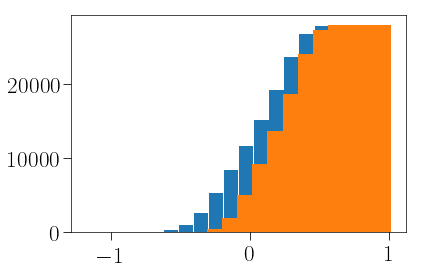

In [39]:
from scipy import stats
bins = np.linspace(-1,1,20)
res = stats.cumfreq(new_table3['col1'], numbins = 20)
res2 = stats.cumfreq(new_table3['col3'], numbins = 20)
bins = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,res.cumcount.size)
plt.bar(bins, res.cumcount, width = res.binsize)
plt.bar(bins, res2.cumcount, width = res2.binsize)

print (bins)
print (res.cumcount)
print (res2.cumcount)

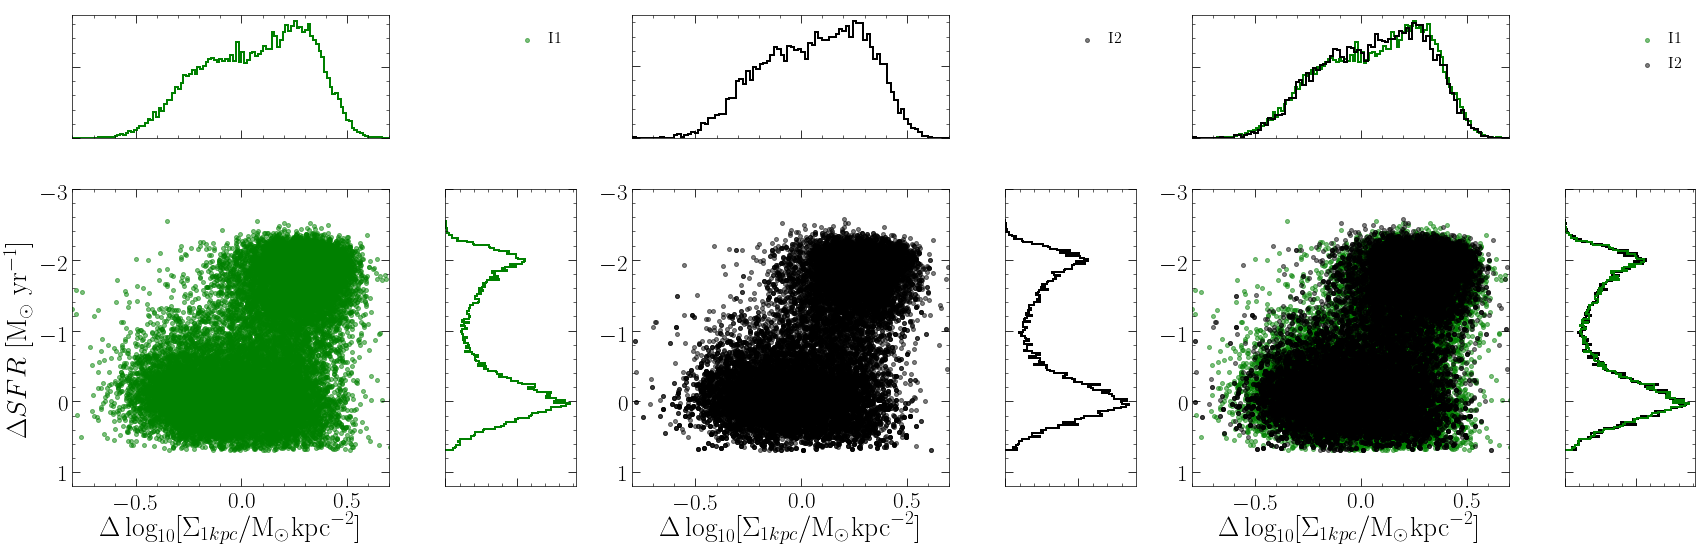

In [40]:
#THIS IS THE IVAN DENSITY SHIT




fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(new_table2['col1'], new_table2['col0'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(new_table3['col1'], new_table3['col0'], c='green',label='I1', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(new_table3['col1'], bins=150, histtype='step', color='green', density=True, lw=2, label="central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(new_table3['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(new_table2['col3'], new_table2['col2'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(new_table3['col3'], new_table3['col2'], c='black',label='I2', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(new_table3['col3'], bins=150, histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(new_table3['col2'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(new_table3['col1'], new_table3['col0'], c='green',label='I1', alpha=0.5)
ax.scatter(new_table3['col3'], new_table3['col2'], c='black',label='I2', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(new_table3['col1'], bins=150,  histtype='step', color='green', density=True, lw=2, label="central")
ax.hist(new_table3['col3'], bins=150,  histtype='step', color='black', density=True, lw=2, label="satellite")
#ax.hist(data['delta_Sigma_1A'], bins=15,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(new_table3['col2'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="satellite")
ax.hist(new_table3['col0'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="central")
#ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-I1VsI2-Limited.png')

plt.tight_layout()


Go to bottom of notebook for figure 1c

# Back to full data set for colour maps

In [38]:
angdiamdist = Planck15.angular_diameter_distance(data['col5_2'])*(1/un.radian)
R90_KPC = (data['R90_ARCSEC']*un.arcsec)*angdiamdist.to(un.kpc/un.arcsec)
print (R90_KPC)
R90_KPC = Column(name='R90_KPC', data=R90_KPC)
#data.add_column(R90_KPC)
data.replace_column('R90_KPC',R90_KPC )
spirals = data[data['t01_smooth_or_features_a02_features_or_disk_flag']*data['t02_edgeon_a05_no_flag']*data['t04_spiral_a08_spiral_flag'] ==1]
#spirals = data[data['t04_spiral_a08_spiral_debiased']>0.8]
ellipticals = data[data['t01_smooth_or_features_a01_smooth_debiased']>0.8]



[9.73377509 3.20444507 5.96146606 ... 6.52859223 7.56304637 8.19133897] kpc


(array([9.26908928e-04, 6.48836250e-03, 1.52738471e-02, 2.93386826e-02,
        4.27587119e-02, 5.81937605e-02, 7.15734894e-02, 8.47114160e-02,
        1.02927191e-01, 1.13485893e-01, 1.21828073e-01, 1.20901165e-01,
        1.28800041e-01, 1.31419566e-01, 1.22351979e-01, 1.19571252e-01,
        1.10906668e-01, 1.03088393e-01, 9.41820072e-02, 8.33009024e-02,
        7.97141678e-02, 6.89136638e-02, 6.44403207e-02, 5.16247973e-02,
        4.98918806e-02, 4.37662216e-02, 3.84465703e-02, 3.29657175e-02,
        2.73639636e-02, 2.25682174e-02, 2.04725972e-02, 1.72082658e-02,
        1.49111436e-02, 1.33394285e-02, 9.30938967e-03, 1.03168994e-02,
        8.30187997e-03, 6.36746133e-03, 6.04505823e-03, 4.23154076e-03,
        4.91664736e-03, 3.14343028e-03, 3.30463183e-03, 2.74042640e-03,
        1.61201553e-03, 2.29712213e-03, 1.49111436e-03, 1.04781009e-03,
        1.32991281e-03, 1.04781009e-03, 9.26908928e-04, 5.64205435e-04,
        7.65707375e-04, 6.85106599e-04, 4.83604658e-04, 4.433042

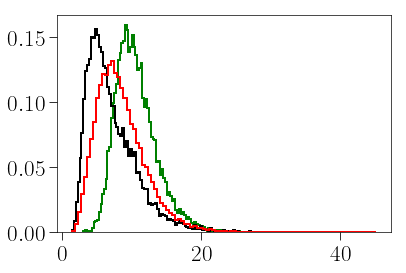

In [39]:
plt.hist(spirals['R90_KPC'], bins=100,  histtype='step', color='green', density=True, lw=2, label="boo")
plt.hist(ellipticals['R90_KPC'], bins=100,  histtype='step', color='black', density=True, lw=2, label="boo")
plt.hist(data['R90_KPC'], bins=100,  histtype='step', color='red', density=True, lw=2, label="boo")


# Figure 1d

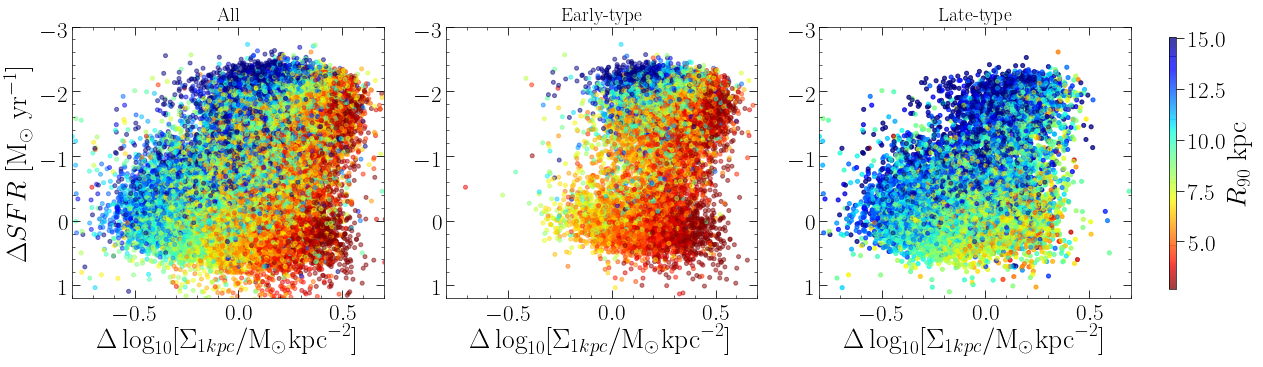

In [40]:
fig = plt.figure(figsize=(21, 5))


ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(data['delta_Sigma_1A'], data['delta_SFR'], c=data['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('All')



ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(ellipticals['delta_Sigma_1A'], ellipticals['delta_SFR'], c=ellipticals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Early-type')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(spirals['delta_Sigma_1A'], spirals['delta_SFR'], c=spirals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Late-type')

sp = ax3.scatter(spirals['delta_Sigma_1A'], spirals['delta_SFR'], c=spirals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colour-all-late-early.png')



In [41]:

low = data[data['AVG_MASS']<=10]
lowS = spirals[spirals['AVG_MASS']<=10]
lowE = ellipticals[ellipticals['AVG_MASS']<=10]

high = data[data['AVG_MASS']>=10.5]
highS = spirals[spirals['AVG_MASS']>=10.5]
highE = ellipticals[ellipticals['AVG_MASS']>=10.5]

middle = data[np.logical_and((data['AVG_MASS'] >= 10), (data['AVG_MASS'] <=10.5))]
middleS = spirals[np.logical_and((spirals['AVG_MASS'] >= 10), (spirals['AVG_MASS'] <=10.5))]
middleE = ellipticals[np.logical_and((ellipticals['AVG_MASS'] >= 10), (ellipticals['AVG_MASS'] <=10.5))]


In [42]:
small = data[data['R90_KPC']<=7]
smallS = spirals[spirals['R90_KPC']<=7]
smallE = ellipticals[ellipticals['R90_KPC']<=7]

large = data[data['R90_KPC']>=11]
largeS = spirals[spirals['R90_KPC']>=11]
largeE = ellipticals[ellipticals['R90_KPC']>=11]


medium = data[np.logical_and((data['R90_KPC'] >= 7), (data['R90_KPC'] <=11))]
mediumS = spirals[np.logical_and((spirals['R90_KPC'] >= 7), (spirals['R90_KPC'] <=11))]
mediumE = ellipticals[np.logical_and((ellipticals['R90_KPC'] >= 7), (ellipticals['R90_KPC'] <=11))]


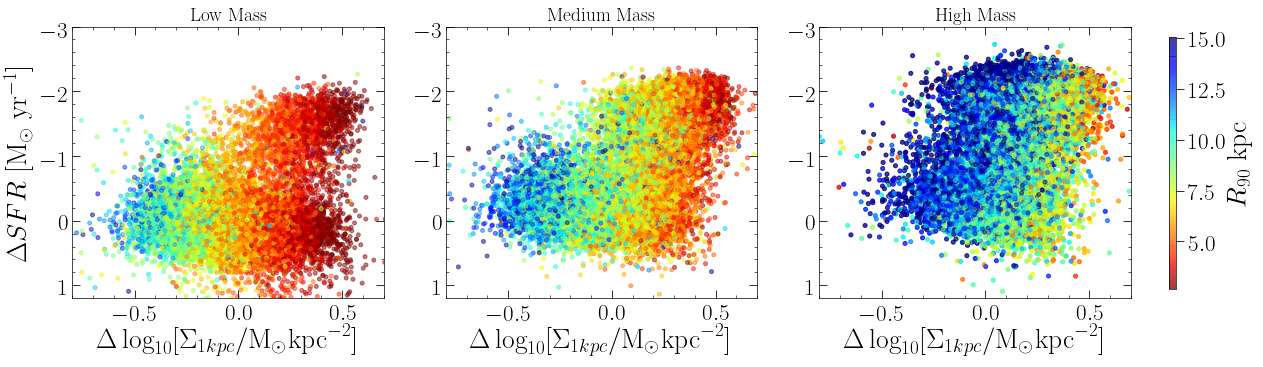

In [43]:
fig = plt.figure(figsize=(21, 5))


ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c=low['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Low Mass')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c=middle['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Medium Mass')

ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c=high['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('High Mass')

sp = ax3.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c=high['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-All-Mass.png')




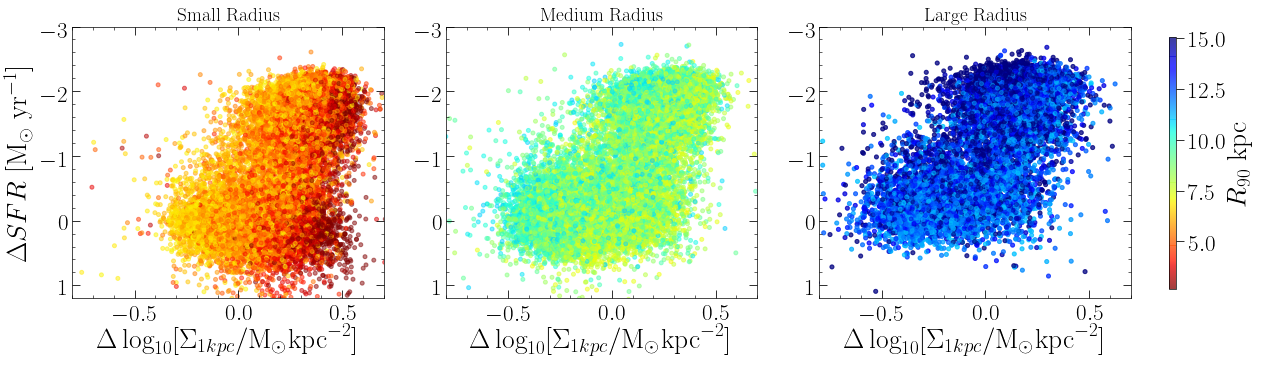

In [44]:
fig = plt.figure(figsize=(21, 5))

ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(small['delta_Sigma_1A'], small['delta_SFR'], c=small['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Small Radius')



ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(medium['delta_Sigma_1A'], medium['delta_SFR'], c=medium['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Medium Radius')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(large['delta_Sigma_1A'], large['delta_SFR'], c=large['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Large Radius')

sp =ax3.scatter(large['delta_Sigma_1A'], large['delta_SFR'], c=large['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-All-Radius.png')

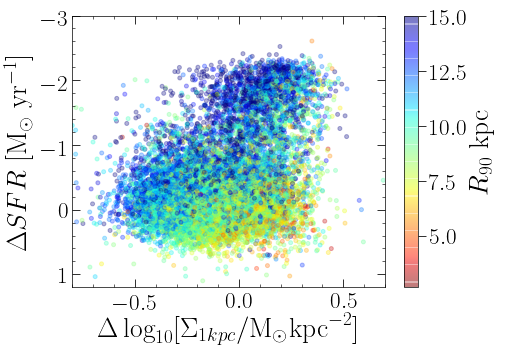

In [45]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(spirals['delta_Sigma_1A'], spirals['delta_SFR'], c=spirals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)
cbar = plt.colorbar()
cbar.set_label(r'$R_{90}$ kpc')



# Figure 1f

In [69]:
fig = plt.figure(figsize=(21, 5))
ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(lowS['delta_Sigma_1A'], lowS['delta_SFR'], c=lowS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Late-type: Low Mass')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(middleS['delta_Sigma_1A'], middleS['delta_SFR'], c=middleS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Late-type: Medium Mass')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(highS['delta_Sigma_1A'], highS['delta_SFR'], c=highS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Late-type: High Mass')

sp = ax3.scatter(highS['delta_Sigma_1A'], highS['delta_SFR'], c=highS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-Late-Mass.png')

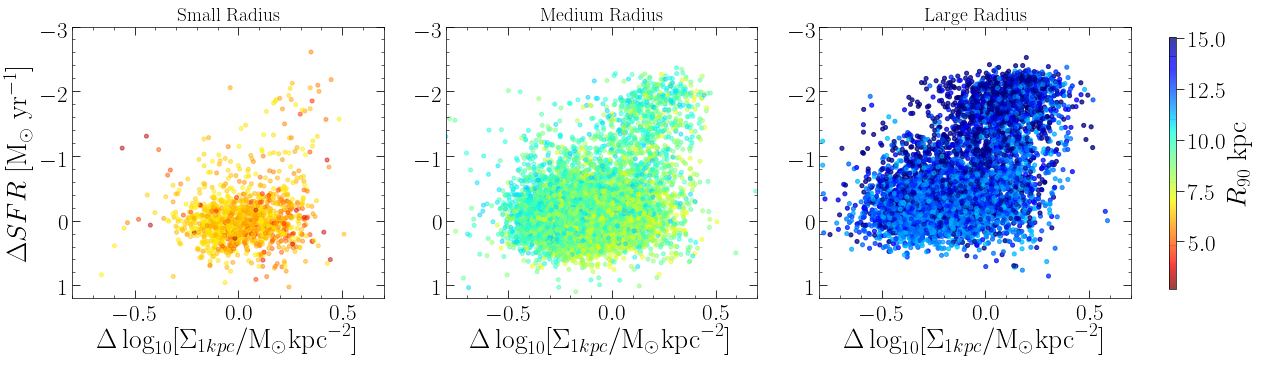

In [47]:
fig = plt.figure(figsize=(21, 5))
ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(smallS['delta_Sigma_1A'], smallS['delta_SFR'], c=smallS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Small Radius')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(mediumS['delta_Sigma_1A'], mediumS['delta_SFR'], c=mediumS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Medium Radius')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(largeS['delta_Sigma_1A'], largeS['delta_SFR'], c=largeS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Large Radius')

sp = ax3.scatter(largeS['delta_Sigma_1A'], largeS['delta_SFR'], c=largeS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-Late-Radius.png')

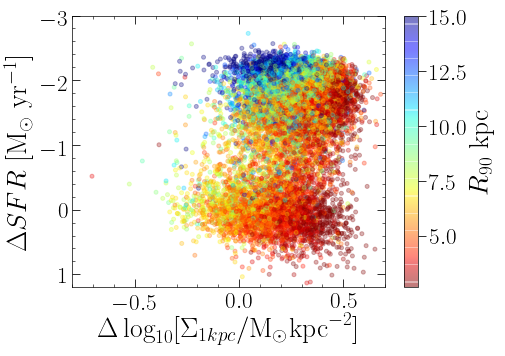

In [48]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(ellipticals['delta_Sigma_1A'], ellipticals['delta_SFR'], c=ellipticals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)
cbar = plt.colorbar()
cbar.set_label(r'$R_{90}$ kpc')



# Figure 1f

In [70]:
fig = plt.figure(figsize=(21, 5))
ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(lowE['delta_Sigma_1A'], lowE['delta_SFR'], c=lowE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Early-type: Low Mass')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(middleE['delta_Sigma_1A'], middleE['delta_SFR'], c=middleE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Early-type: Medium Mass')



ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(highE['delta_Sigma_1A'], highE['delta_SFR'], c=highE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Early-type: High Mass')

sp = ax3.scatter(highE['delta_Sigma_1A'], highE['delta_SFR'], c=highE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-Early-Mass.png')

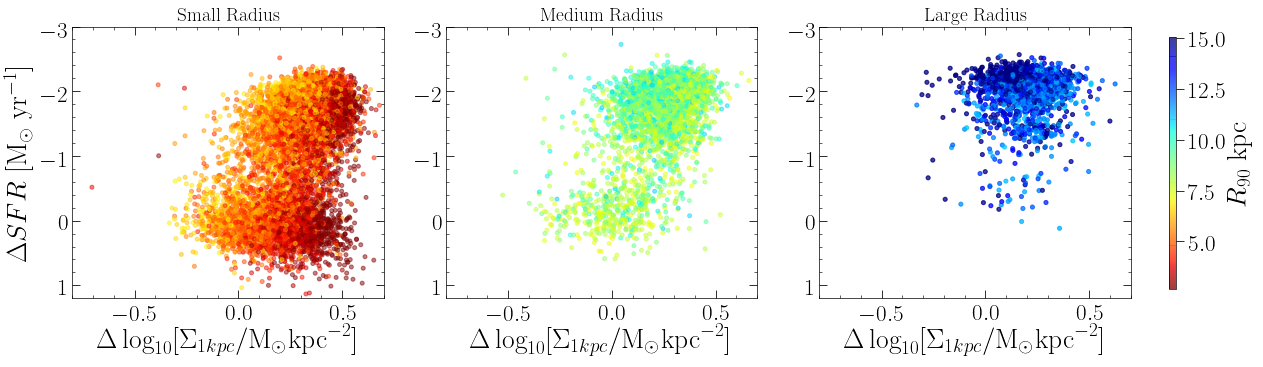

In [50]:
fig = plt.figure(figsize=(21, 5))
ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(smallE['delta_Sigma_1A'], smallE['delta_SFR'], c=smallE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Small Radius')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(mediumE['delta_Sigma_1A'], mediumE['delta_SFR'], c=mediumE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Medium Radius')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(largeE['delta_Sigma_1A'], largeE['delta_SFR'], c=largeE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('Large Radius')

sp = ax3.scatter(largeE['delta_Sigma_1A'], largeE['delta_SFR'], c=largeE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')

plt.savefig('figures/PDDP-Colours-Early-Radius.png')

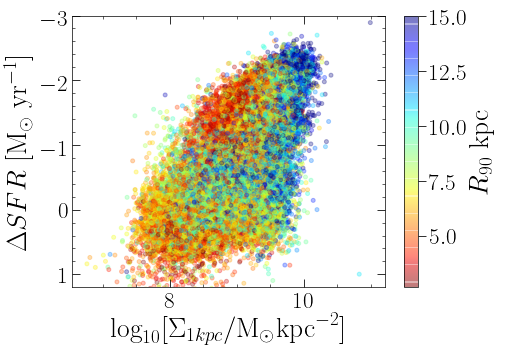

In [51]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['Sigma_1'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(data['Sigma_1'], data['delta_SFR'], c=data['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
#plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)
cbar = plt.colorbar()
cbar.set_label(r'$R_{90}$ kpc')



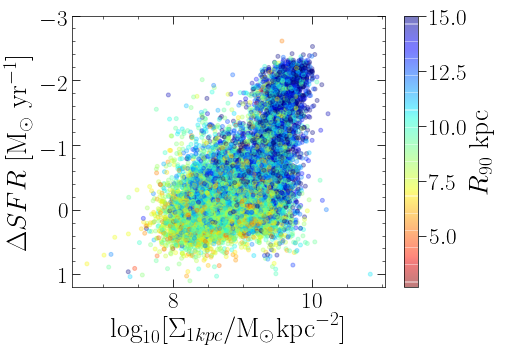

In [52]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['Sigma_1'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(spirals['Sigma_1'], spirals['delta_SFR'], c=spirals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
#plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)
cbar = plt.colorbar()
cbar.set_label(r'$R_{90}$ kpc')


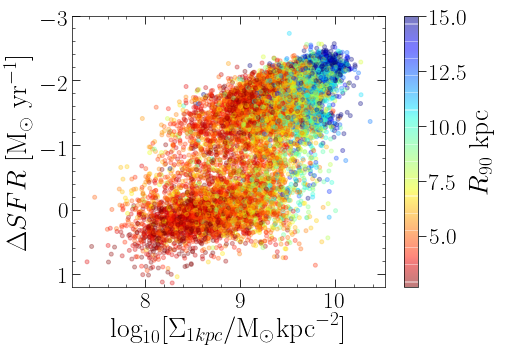

In [53]:
plt.figure(figsize=(7, 5))
#ax4 = plt.subplot(211)
H, X, Y = np.histogram2d(data['Sigma_1'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
plt.scatter(ellipticals['Sigma_1'], ellipticals['delta_SFR'], c=ellipticals['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.3)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
plt.xlabel(r'$\log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
#plt.xlim(-0.8, 0.7)
plt.ylim(1.2,-3)
cbar = plt.colorbar()
cbar.set_label(r'$R_{90}$ kpc')


In [54]:
b1 = data[data['IVAN_DENSITY']<=np.percentile(data['IVAN_DENSITY'], 33)]

b3 = data[data['IVAN_DENSITY']>=np.percentile(data['IVAN_DENSITY'], 66)]


b2 = data[np.logical_and((data['IVAN_DENSITY'] >= np.percentile(data['IVAN_DENSITY'], 33)), (data['IVAN_DENSITY'] <=np.percentile(data['IVAN_DENSITY'], 66)))]


-2.1056
2.3115


(array([4.00000699e-04, 0.00000000e+00, 0.00000000e+00, 4.00001779e-04,
        4.00001779e-04, 0.00000000e+00, 1.60000280e-03, 1.60000712e-03,
        2.80001245e-03, 4.80002135e-03, 2.40001067e-03, 1.28000224e-02,
        1.04000463e-02, 1.68000747e-02, 2.48001103e-02, 4.12000720e-02,
        5.04002241e-02, 8.40003736e-02, 1.04800466e-01, 1.27200566e-01,
        1.58000276e-01, 1.94400865e-01, 2.56801142e-01, 2.65201179e-01,
        3.22401434e-01, 3.64801130e-01, 4.27201323e-01, 4.48401994e-01,
        5.07601572e-01, 5.51202451e-01, 6.24001933e-01, 6.36402830e-01,
        6.61602050e-01, 6.78403017e-01, 6.86003051e-01, 6.60802047e-01,
        7.00802644e-01, 7.04803134e-01, 6.32802387e-01, 6.48402446e-01,
        6.40002414e-01, 6.18002331e-01, 5.63602126e-01, 5.75202364e-01,
        5.54402092e-01, 5.03601900e-01, 4.96001913e-01, 4.60001774e-01,
        4.38401691e-01, 4.16801608e-01, 4.18001577e-01, 3.93601485e-01,
        3.74401539e-01, 3.49601201e-01, 3.34401487e-01, 3.204012

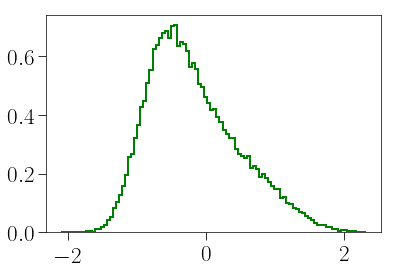

In [55]:
print (min(data['IVAN_DENSITY']))
print (max(data['IVAN_DENSITY']))
plt.hist(data['IVAN_DENSITY'], bins=100,  histtype='step', color='green', density=True, lw=2, label="boo")


In [56]:
import numpy as np
from scipy import stats

a = stats.mode(data['IVAN_DENSITY'])

print (a)

ModeResult(mode=array([-0.4244], dtype=float32), count=array([13]))


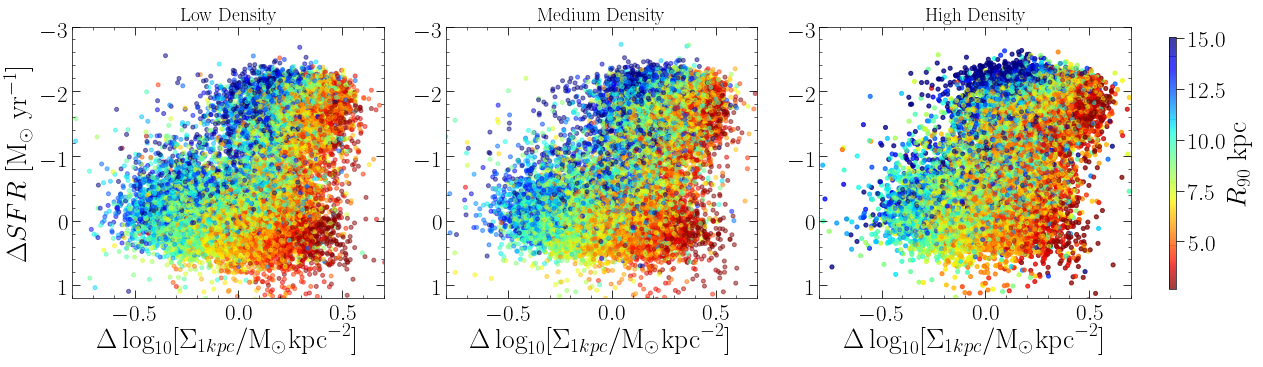

In [57]:
fig = plt.figure(figsize=(21, 5))
ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(b1['delta_Sigma_1A'], b1['delta_SFR'], c=b1['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Low Density')



ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax2.scatter(b2['delta_Sigma_1A'], b2['delta_SFR'], c=b2['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Medium Density')


ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax3.scatter(b3['delta_Sigma_1A'], b3['delta_SFR'], c=b3['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('High Density')

sp = ax3.scatter(b3['delta_Sigma_1A'], b3['delta_SFR'], c=b3['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


plt.savefig('figures/PDDP-Colours-IVANDENSITY-All.png')

In [58]:
I3 = data[data['IVAN_DENSITY']<=999.9]

I1 = I3[I3['IVAN_DENSITY']<=np.percentile(I3['IVAN_DENSITY'], 50)]

I2 = I3[I3['IVAN_DENSITY']>=np.percentile(I3['IVAN_DENSITY'], 50)]

#I1 = data[data['IVAN_DENSITY']<=np.percentile(data['IVAN_DENSITY'], 50)]

#I2 = data[data['IVAN_DENSITY']>=np.percentile(data['IVAN_DENSITY'], 50)]





In [59]:
KS  = ks_2samp(I1['delta_Sigma_1A'][np.isfinite(I1['delta_Sigma_1A'])],I2['delta_Sigma_1A'][np.isfinite(I2['delta_Sigma_1A'])] )
AD = anderson_ksamp([I1['delta_Sigma_1A'][np.isfinite(I1['delta_Sigma_1A'])],I2['delta_Sigma_1A'][np.isfinite(I2['delta_Sigma_1A'])]])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)


Anderson_ksampResult(statistic=374.3922536396818, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=inf)
Ks_2sampResult(statistic=0.0955157426057458, pvalue=8.85533917662179e-113)
-inf


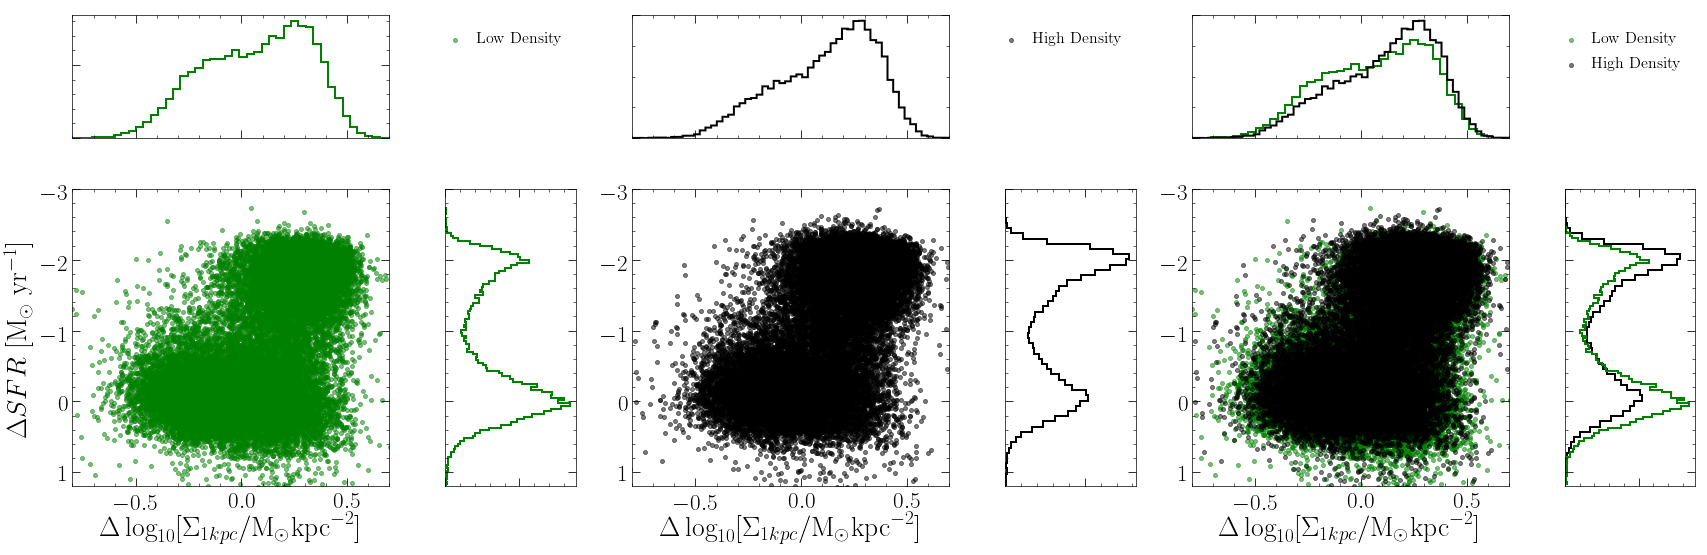

In [60]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(I1['delta_Sigma_1A'], I1['delta_SFR'], c='green',label='Low Density', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(I1['delta_Sigma_1A'], bins=150, histtype='step', color='green', density=True, lw=2, label="Low Density")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(I1['delta_SFR'], bins=150 ,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Low Density")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(I2['delta_Sigma_1A'], I2['delta_SFR'], c='black',label='High Density', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(I2['delta_Sigma_1A'], bins=1000, histtype='step', color='black', density=True, lw=2, label="High Density")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(I2['delta_SFR'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="High Density")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(I1['delta_Sigma_1A'], I1['delta_SFR'], c='green',label='Low Density', alpha=0.5)
ax.scatter(I2['delta_Sigma_1A'], I2['delta_SFR'], c='black',label='High Density', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(I1['delta_Sigma_1A'], bins=150,  histtype='step', color='green', density=True, lw=2, label="Low Density")
ax.hist(I2['delta_Sigma_1A'], bins=1000,  histtype='step', color='black', density=True, lw=2, label="High Density")
#ax.hist(data['delta_Sigma_1A'], bins=150,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(I2['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="High Density")
ax.hist(I1['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="Low Density")
#ax.hist(data['delta_SFR'], bins=150, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#ax.legend(frameon=False, loc=2)

plt.savefig('figures/PDDP-Colours-IVANDENSITY-GB.png')

plt.tight_layout()

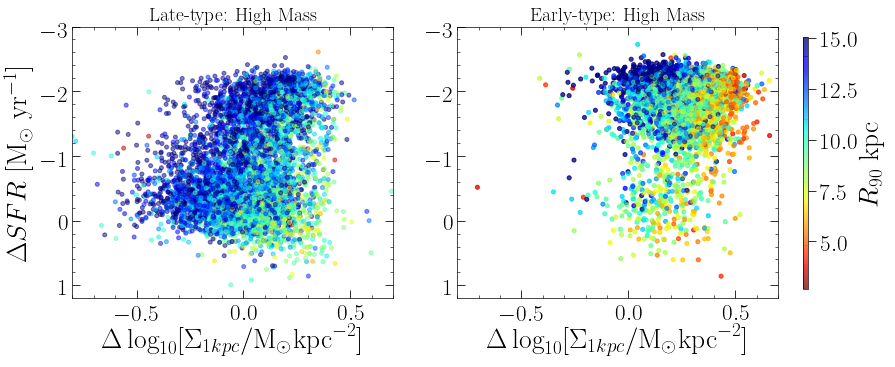

In [61]:
fig = plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax1.scatter(highS['delta_Sigma_1A'], highS['delta_SFR'], c=highS['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('Late-type: High Mass')


ax2 = plt.subplot(122)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
ax2.scatter(highE['delta_Sigma_1A'], highE['delta_SFR'], c=highE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('Early-type: High Mass')

sp = ax2.scatter(highE['delta_Sigma_1A'], highE['delta_SFR'], c=highE['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'$R_{90}$ kpc')


In [62]:
mean_R90 = np.mean(data['R90_KPC'])
print (mean_R90)

8.433446227613702


In [63]:
print ((3/mean_R90)*100)

35.572646330240126


# Centrals and satelites removing N=1 etc

In [73]:
data = Table.read('Yang_GZ3')
yang = Table.read('yang_galaxy_DR7.fits')
groups = yang.group_by('groupID')
diff = np.diff(groups.groups.indices)
Ngalgroup = Column(name='Ngalgroup', data=np.nan*np.ones(len(data)))
for n in trange(len(data)):
    if np.isfinite(data[n]['groupID']):
        idx = np.searchsorted(groups.groups.keys['groupID'].data, data[n]['groupID'])
        Ngalgroup[n] = diff[idx]
    else:
        Ngalgroup[n] = np.nan

100%|██████████| 56598/56598 [02:27<00:00, 383.32it/s]


In [74]:
print (Ngalgroup)

Ngalgroup
---------
      1.0
      2.0
      1.0
      2.0
      2.0
      1.0
      1.0
      1.0
      1.0
      1.0
      ...
      1.0
      5.0
      8.0
      8.0
      1.0
      1.0
      1.0
      1.0
      1.0
      1.0
      1.0
Length = 56598 rows


In [75]:
data.add_column(Ngalgroup)

In [76]:
def ms_sfr(mass, z):
    return (mass/1e9) * 2.5 * (mass/1e10)**(-0.1) * (Planck15.age(z).to(un.Gyr)/(3.5*un.Gyr))**(-2.2) # sol mass per year

delta_SFR = MaskedColumn(name='delta_SFR', data=data['AVG_SFR'] - np.log10(ms_sfr(10**data['AVG_MASS'], data['col5_2'])), mask=data['AVG_MASS'].mask)
data.add_column(delta_SFR)

M = data['AVG_MASS']
b = [-0.12441002*i**2 + 3.3532002*i -12.08089019 - 0.21 for i in M]
delta_Sigma_1A = MaskedColumn(name = "delta_Sigma_1A", data = np.subtract(data['Sigma_1'], b) , dtype=np.float64)
data.add_column(delta_Sigma_1A)
#data.replace_column('delta_Sigma_1A',delta_Sigma_1A )


In [77]:
angdiamdist = Planck15.angular_diameter_distance(data['REDSHIFT'])*(1/un.radian)
R90_KPC = (data['R90_ARCSEC']*un.arcsec)*angdiamdist.to(un.kpc/un.arcsec)
print (R90_KPC)
R90_KPC = Column(name='R90_KPC', data=R90_KPC)
data.add_column(R90_KPC)
#data.replace_column('R90_KPC',R90_KPC )
spirals = data[data['t01_smooth_or_features_a02_features_or_disk_flag']*data['t02_edgeon_a05_no_flag']*data['t04_spiral_a08_spiral_flag'] ==1]
#spirals = data[data['t04_spiral_a08_spiral_debiased']>0.8]
ellipticals = data[data['t01_smooth_or_features_a01_smooth_debiased']>0.8]



[9.73198745 3.20866031 5.96115598 ... 6.53603045 7.59448168 8.20492375] kpc


In [78]:
n0 = data[data['Ngalgroup']==0]
n1 = data[data['Ngalgroup']==1]
n210 = data[np.logical_and((data['Ngalgroup'] >= 2), (data['Ngalgroup'] <=10))]
n11p = data[data['Ngalgroup']>=11]


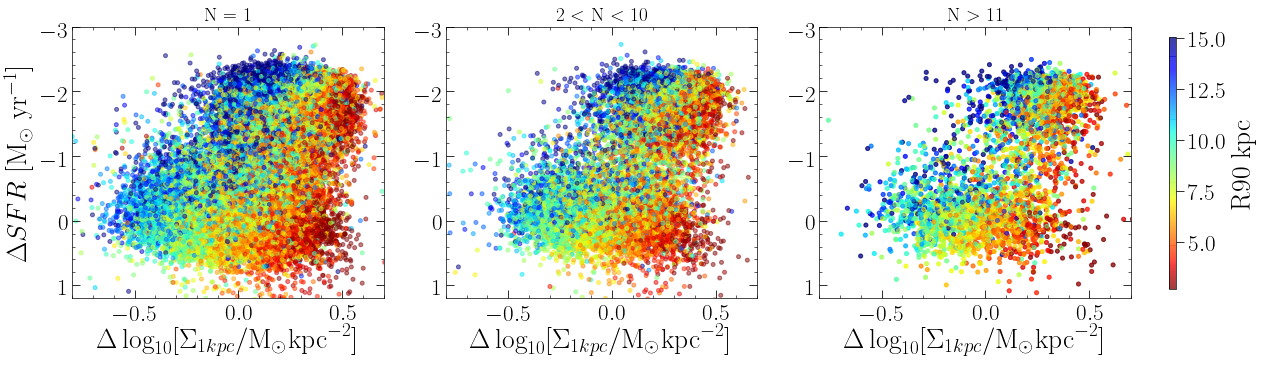

In [79]:
fig = plt.figure(figsize=(21, 5))


ax1 = plt.subplot(131)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
ax1.scatter(n1['delta_Sigma_1A'], n1['delta_SFR'], c=n1['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
#plt.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax1.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax1.set_xlim(-0.8, 0.7)
ax1.set_ylim(1.2,-3)
ax1.set_title('N = 1')


ax2 = plt.subplot(132)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
#plt.scatter(high['delta_Sigma_1A'], high['delta_SFR'], c='b', alpha=0.5)
ax2.scatter(n210['delta_Sigma_1A'], n210['delta_SFR'], c=n210['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top="on", right='on')
#ax2.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax2.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax2.set_xlim(-0.8, 0.7)
ax2.set_ylim(1.2,-3)
ax2.set_title('2 $<$ N $<$ 10')

ax3 = plt.subplot(133)
H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=20, range=((7.5, 10.5),(4,10.5)))
#cont = plt.contour(X[:-1], Y[:-1], H.T, colors='k', levels=np.nanpercentile(H[np.nonzero(H)], [33, 66, 90, 95, 99]))
#ax2.scatter(low['delta_Sigma_1A'], low['delta_SFR'], c='r', alpha=0.5)
ax3.scatter(n11p['delta_Sigma_1A'], n11p['delta_SFR'], c=n11p['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
#ax2.scatter(middle['delta_Sigma_1A'], middle['delta_SFR'], c='orange', alpha=0.5)
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='black', marker='o', label="Quenched AGN")
#plt.scatter(delta_Sigma_1[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='black', marker='s', label="SF AGN")
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', top="on", right='on')
#ax3.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax3.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax3.set_xlim(-0.8, 0.7)
ax3.set_ylim(1.2,-3)
ax3.set_title('N $>$ 11')



sp = ax3.scatter(n11p['delta_Sigma_1A'], n11p['delta_SFR'], c=n11p['R90_KPC'], vmin = np.percentile(data['R90_KPC'], 1), vmax = np.percentile(data['R90_KPC'], 95), cmap = plt.cm.jet_r, alpha=0.5)
plt.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
cbar = plt.colorbar(sp, cax=cbar_ax)
cbar.set_label(r'R90 kpc')

plt.savefig('figures/PDDP-Colours-All-N.png')


In [80]:
central = data[data['col4_1']==1]
satellite = data[data['col4_1']==2]

N11central = central[central['Ngalgroup']>=11]
N11satellite = satellite[satellite['Ngalgroup']>=11]

N2central = central[np.logical_and((central['Ngalgroup'] >= 2), (central['Ngalgroup'] <=10))]
N2satellite = satellite[np.logical_and((satellite['Ngalgroup'] >= 2), (satellite['Ngalgroup'] <=10))]


In [81]:
KS  = ks_2samp(N2central['delta_Sigma_1A'][np.isfinite(N2central['delta_Sigma_1A'])],N2satellite['delta_Sigma_1A'][np.isfinite(N2satellite['delta_Sigma_1A'])] )
AD = anderson_ksamp([N2central['delta_Sigma_1A'][np.isfinite(N2central['delta_Sigma_1A'])],N2satellite['delta_Sigma_1A'][np.isfinite(N2satellite['delta_Sigma_1A'])]])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)


Anderson_ksampResult(statistic=-0.808596058087515, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.8207765331443688)
Ks_2sampResult(statistic=0.010678156641797276, pvalue=0.8794672918214929)
0.22654632542782577


# Figure 1c

In [82]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(N2central['delta_Sigma_1A'], N2central['delta_SFR'], c='green',label='Centrals', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'xx-large')

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(N2central['delta_Sigma_1A'], bins=150, histtype='step', color='green', density=True, lw=2, label="N2central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(N2central['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="N2central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(N2satellite['delta_Sigma_1A'], N2satellite['delta_SFR'], c='black',label='Satellites', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'xx-large')

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(N2satellite['delta_Sigma_1A'], bins=150, histtype='step', color='black', density=True, lw=2, label="N2satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(N2satellite['delta_SFR'], bins=150, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="N2satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=150, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(N2central['delta_Sigma_1A'], N2central['delta_SFR'], c='green',label='Centrals', alpha=0.5)
ax.scatter(N2satellite['delta_Sigma_1A'], N2satellite['delta_SFR'], c='black',label='Satellites', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels, fontsize = 'xx-large')

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(N2central['delta_Sigma_1A'], bins=150,  histtype='step', color='green', density=True, lw=2, label="N2central")
ax.hist(N2satellite['delta_Sigma_1A'], bins=150,  histtype='step', color='black', density=True, lw=2, label="N2satellite")
#ax.hist(data['delta_Sigma_1A'], bins=50,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(N2satellite['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="N2satellite")
ax.hist(N2central['delta_SFR'], bins=150,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="N2central")
#ax.hist(data['delta_SFR'], bins=50, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-SatVsCent-N210.png')

plt.tight_layout()

In [83]:
KS  = ks_2samp(N2central['delta_Sigma_1A'][np.isfinite(N2central['delta_Sigma_1A'])],N2satellite['delta_Sigma_1A'][np.isfinite(N2satellite['delta_Sigma_1A'])])

AD = anderson_ksamp([N2central['delta_Sigma_1A'][np.isfinite(N2central['delta_Sigma_1A'])],N2satellite['delta_Sigma_1A'][np.isfinite(N2satellite['delta_Sigma_1A'])]])
print (KS)
print (AD)
from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (sigma)

Ks_2sampResult(statistic=0.010678156641797276, pvalue=0.8794672918214929)
Anderson_ksampResult(statistic=-0.808596058087515, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.8207765331443688)
0.22654632542782577


In [84]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=50, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(N11central['delta_Sigma_1A'], N11central['delta_SFR'], c='green',label='N11central', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(N11central['delta_Sigma_1A'], bins=50, histtype='step', color='green', density=True, lw=2, label="N11central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(N11central['delta_SFR'], bins=50,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="N11central")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=50, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(N11satellite['delta_Sigma_1A'], N11satellite['delta_SFR'], c='black',label='N11satellite', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(N11satellite['delta_Sigma_1A'], bins=50, histtype='step', color='black', density=True, lw=2, label="N11satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(N11satellite['delta_SFR'], bins=50, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="N11satellite")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


H, X, Y = np.histogram2d(data['delta_Sigma_1A'],data['delta_SFR'], bins=50, range=((7.5, 10.5),(4,10.5)))
ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(N11central['delta_Sigma_1A'], N11central['delta_SFR'], c='green',label='N11central', alpha=0.5)
ax.scatter(N11satellite['delta_Sigma_1A'], N11satellite['delta_SFR'], c='black',label='N11satellite', alpha=0.5)
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] < -0.45)], c='magenta', marker='o', label="Quenched AGN")
#ax.scatter(delta_Sigma_1A[np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], data['delta_SFR'][np.logical_and(data['BPT_FLAG_SNR_2']==1, data['delta_SFR'] > -0.45)], c='magenta', marker='s', label="SF AGN")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylabel(r'$\Delta SFR$ $[\rm{M}_{\odot}$ $\rm{yr}^{-1}]$')
ax.set_xlabel(r'$\Delta \log_{10}[\Sigma_{1kpc}/\rm{M}_{\odot}\rm{kpc}^{-2}]$')
ax.set_xlim(-0.8, 0.7)
ax.set_ylim(1.2,-3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(N11central['delta_Sigma_1A'], bins=50,  histtype='step', color='green', density=True, lw=2, label="N11central")
ax.hist(N11satellite['delta_Sigma_1A'], bins=50,  histtype='step', color='black', density=True, lw=2, label="N11satellite")
ax.hist(data['delta_Sigma_1A'], bins=50,  range=(-0.8, 0.7), histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(-0.8, 0.7)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
#ax.hist(ellipticals['delta_SFR'], bins=15, orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="Ellipticals")
ax.hist(N11satellite['delta_SFR'], bins=50,orientation='horizontal', histtype='step', color='black', density=True, lw=2, label="N11satellite")
ax.hist(N11central['delta_SFR'], bins=50,orientation='horizontal', histtype='step', color='green', density=True, lw=2, label="N11central")
ax.hist(data['delta_SFR'], bins=50, orientation='horizontal',histtype='step', color='blue', density=True, lw=2, label="All")
#ax.set_xlabel(r'$\log_{10}[\rm{M}_{BH}/\rm{M}_{\odot}]$')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(1.2,-3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)
plt.savefig('figures/PDDP-SatVsCent-N11.png')

plt.tight_layout()